# $\varepsilon-\delta$ Differential Privacy Implemenation & Test

The purpose of this experiment is to observe the performance of DP NB with added $\delta$ parameter. Parameter was added by modifying IBM diffpriv libraries. To keep consistency, I created a subclass method of DP NB and introduced $\delta$.

In [1]:
def run_CLF_DP(x_train, y_train, x_test, y_test, deltas, epsilon):
#     # ignore this warning, let the class calculate sensitivity automatically.
#     import warnings
#     warnings.simplefilter("ignore", PrivacyLeakWarning)
    import diffprivlib
    import numpy as np
    from sklearn import preprocessing
    # must append dir for parallel exec
    sys.path.append('/home/krudavsk/dp_test')
    from dp_delta_revised import GaussianNBEpsDelta
    from linreg_delta import LinearRegressionDeltaDP
    
    iterations=100
    results=[]
    
    acc=[]
    for delta in deltas:
        acc_delta=np.zeros(iterations)
        for i in range(iterations):
            clf_nb_dp_delta = GaussianNBEpsDelta(epsilon=epsilon, delta = delta)
            clf_nb_dp_delta.fit(x_train, y_train)
            acc_delta[i] = metrics.accuracy_score(y_test, clf_nb_dp_delta.predict(x_test))
        acc.append((acc_delta.mean(), acc_delta.min(), acc_delta.max(), acc_delta))
    results.append(acc)
    
    acc=[]
    var = np.zeros(iterations)
    for i in range(iterations):
        mod = diffprivlib.models.LogisticRegression(epsilon=epsilon, n_jobs=-1)
        mod.fit(x_train, y_train)
        var[i] = metrics.accuracy_score(y_test, mod.predict(x_test))
    acc.append((var.mean(), var.min(), var.max(), var))
    results.append(acc)
    
    acc=[]
    var = np.zeros(iterations)
    for i in range(iterations):
        mod = diffprivlib.models.LinearRegression(epsilon=epsilon, fit_intercept=False, n_jobs=-1)
        mod.fit(x_train, y_train)
        var[i] = metrics.mean_squared_error(y_test, mod.predict(x_test))
    acc.append((var.mean(), var.min(), var.max(), var))
    results.append(acc)
    
    acc=[]
    for delta in deltas:
        acc_delta=np.zeros(iterations)
        for i in range(iterations):
            mod = LinearRegressionDeltaDP(epsilon=epsilon, delta = delta)
            mod.fit(x_train, y_train)
            acc_delta[i] = metrics.mean_squared_error(y_test, mod.predict(x_test))
        acc.append((acc_delta.mean(), acc_delta.min(), acc_delta.max(), acc_delta))
    results.append(acc)

    return results

In [2]:
def run_LOGREG_DP(x_train, y_train, x_test, y_test, deltas, epsilon):
#     # ignore this warning, let the class calculate sensitivity automatically.
#     import warnings
#     warnings.simplefilter("ignore", PrivacyLeakWarning)
    import diffprivlib
    import numpy as np
    from sklearn import preprocessing
    # must append dir for parallel exec
    sys.path.append('/home/krudavsk/dp_test')
    from dp_delta_revised import GaussianNBEpsDelta
    from linreg_delta import LinearRegressionDeltaDP
    
    iterations=10
    results=[]
    
    acc=[]
    var = np.zeros(iterations)
    for i in range(iterations):
        mod = diffprivlib.models.LogisticRegression(epsilon=epsilon, n_jobs=-1)
        mod.fit(x_train, y_train)
        var[i] = metrics.accuracy_score(y_test, mod.predict(x_test))
    acc.append((var.mean(), var.min(), var.max(), var))
    results.append(acc)

    return results

In [3]:
def run_REG_DP(x_train, y_train, x_test, y_test, deltas, epsilon):
#     # ignore this warning, let the class calculate sensitivity automatically.
#     import warnings
#     warnings.simplefilter("ignore", PrivacyLeakWarning)
    import diffprivlib
    import numpy as np
    from sklearn import preprocessing
    # must append dir for parallel exec
    sys.path.append('/home/krudavsk/dp_test')
    from dp_delta_revised import GaussianNBEpsDelta
    from linreg_delta import LinearRegressionDeltaDP
    
    iterations=10
    results=[]
    
    acc=[]
    var = np.zeros(iterations)
    for i in range(iterations):
        mod = diffprivlib.models.LinearRegression(epsilon=epsilon, fit_intercept=False, n_jobs=-1)
        mod.fit(x_train, y_train)
        var[i] = metrics.mean_squared_error(y_test, mod.predict(x_test))
    acc.append((var.mean(), var.min(), var.max(), var))
    results.append(acc)
    
    acc=[]
    for delta in deltas:
        acc_delta=np.zeros(iterations)
        for i in range(iterations):
            mod = LinearRegressionDeltaDP(epsilon=epsilon, delta = delta)
            mod.fit(x_train, y_train)
            acc_delta[i] = metrics.mean_squared_error(y_test, mod.predict(x_test))
        acc.append((acc_delta.mean(), acc_delta.min(), acc_delta.max(), acc_delta))
    results.append(acc)

    return results

In [4]:
def run_dataset(x, y, deltas=[0.01], mode='clf', name='', num_points = 25):
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, random_state=42)
    
    # parallelize epsilon testing
    import ipyparallel as ipp
    from functools import partial

    import time
    start = time.time()

    from sklearn.naive_bayes import GaussianNB
    from sklearn import metrics
    import diffprivlib.models as dp
    import numpy as np
    from dp_delta_revised import GaussianNBEpsDelta

    import math

    min_=1e-1
    max_=1e1

    epsilons = np.logspace(math.log(min_, 10), math.log(max_, 10), num_points)
    # one recommendation is 2**-30 from:
    # https://www.cs.princeton.edu/~smattw/Teaching/521fa17lec22.pdf
    # another recommendation is 1/(100*n) from
    # https://crypto.stackexchange.com/questions/44299/differential-privacy-why-delta-negligible-on-the-row-numbers

    c = ipp.Client()
    print(f'Running on {c.ids} cores')
    v = c[:]
#     v.activate()
    result=[]
    with v.sync_imports():
        import sys
        from sklearn import metrics
        import diffprivlib.models
        import numpy
        
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LinearRegression


    if mode == 'clf':
        result=v.map_sync(partial(run_CLF_DP, x_train, y_train, x_test, y_test, deltas), epsilons)
        models=[GaussianNB(), 
                LogisticRegression(n_jobs=-1), 
                LinearRegression(n_jobs=-1, fit_intercept=False),
                LinearRegression(n_jobs=-1, fit_intercept=False)]
    elif mode == 'logreg':    
        result=v.map_sync(partial(run_LOGREG_DP, x_train, y_train, x_test, y_test, deltas), epsilons)
        models=[LogisticRegression(n_jobs=-1)]    
    else:
        result=v.map_sync(partial(run_REG_DP, x_train, y_train, x_test, y_test, deltas), epsilons)
        models=[
                LinearRegression(n_jobs=-1, fit_intercept=False),
                LinearRegression(n_jobs=-1, fit_intercept=False)
            ]
    
    for counter, model in enumerate(models):
        model_res = [l[counter] for l in result]

        # get raw result
        model.fit(x_train, y_train)        
        try:
            acc_raw=metrics.accuracy_score(y_test, model.predict(x_test))
            metric='Accuracy'
        except:
            acc_raw=metrics.mean_squared_error(y_test, model.predict(x_test))
            metric='MSE'

        import statistics as stat
        import matplotlib.pyplot as plt
        import math

        MEAN=0; MIN=1; MAX=2; PTS=3

        plt.figure(figsize=(14,7))
        plt.style.use('seaborn')
        plt.axhline(y=acc_raw, color='r', linestyle = '--', label="Non-Private")
        for i in range(len(model_res[-1])):
            d = deltas[i] if len(model_res[-1])==len(deltas) else 0
            mean_ = np.array([l[i][MEAN] for l in model_res])
            plt.semilogx(epsilons, mean_, label=f"delta = {d}")
            plt.xlabel("epsilon")
            plt.ylabel(f'{str(metric)}')
            delt = 'Pure DP' if d==0 else ''
            title=f'{repr(model).split("(")[0]}'
            plt.title(f"{title}")
            plt.legend()
            left, right = epsilons[0], epsilons[-1]
#             plt.xlim(left, 1.0) if 'GaussianNB' in title else plt.xlim(left, right)
        plt.savefig(f'{name}_accuracy_samples_{x.shape}_model_{repr(model).split("(")[0]}_{delt}.svg', format='svg')
        plt.show()

        for i in range(len(model_res[-1])):
            plt.figure(figsize=(14,7))
            pts_ = np.array([l[i][PTS] for l in model_res])
            plt.boxplot(pts_.T, showfliers=False)
            plt.xlabel("epsilon")
            plt.ylabel(f'{str(metric)}')
            plt.xticks([], [])
            d = deltas[i] if len(model_res[-1])==len(deltas) else 0
            delt = 'Pure DP' if d==0 else ''
            title=f'{repr(model).split("(")[0]}'
            plt.title(f"Box Plots for Curve-Smoothing at Delta = {d}")
#             plt.xlim(left, 1.0) if 'GaussianNB' in title else plt.xlim(left, right)
            plt.savefig(f'{name}_boxplot_delta_{d}_samples_{x.shape}_model_{title}.svg', format='svg')
            plt.show()
        
#     c.purge_results()
    v.results.clear()
    c.results.clear()
    c.metadata.clear()

    print(f"\nTotal execution time: {round(time.time() - start, 0)} s\n")

*********** RUNNING CARS: 1728 ENTRIES ***********

Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] cores
importing sys on engine(s)
importing metrics from sklearn on engine(s)
importing diffprivlib.models on engine(s)
importing numpy on engine(s)


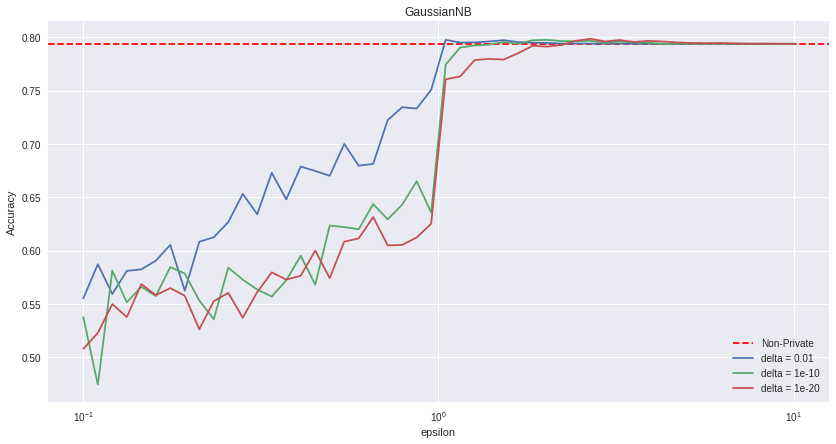

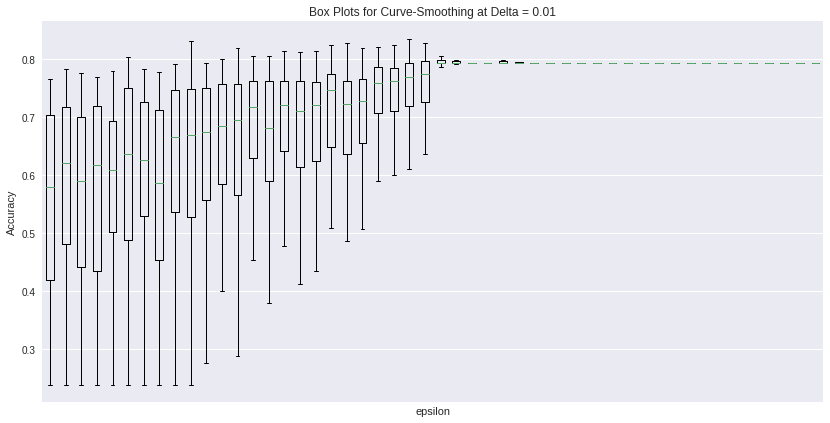

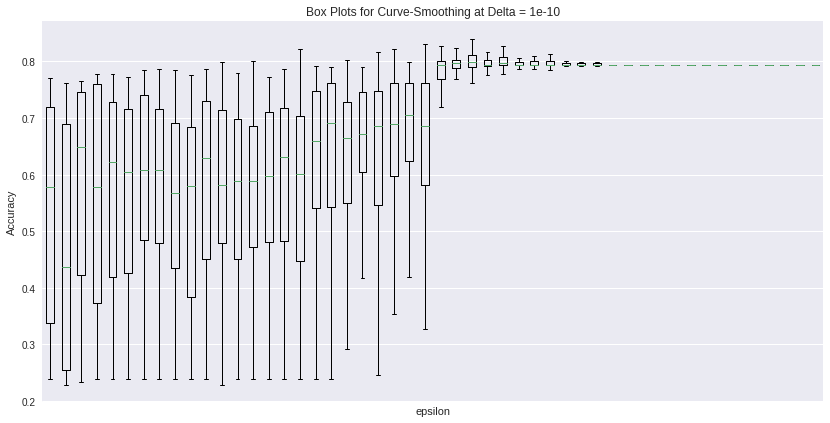

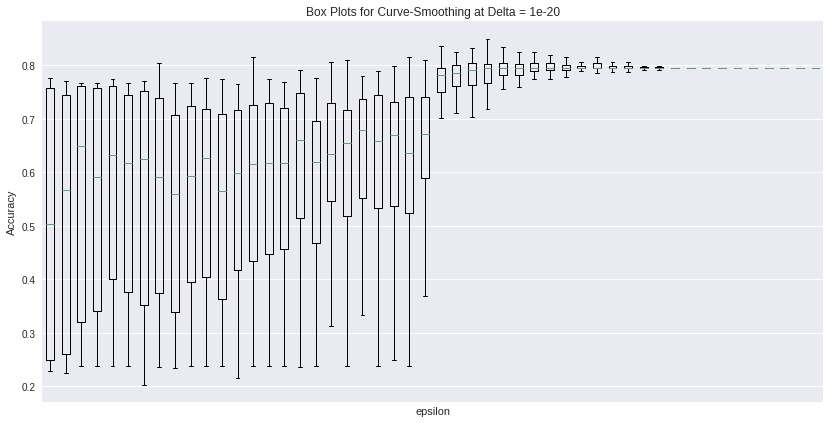

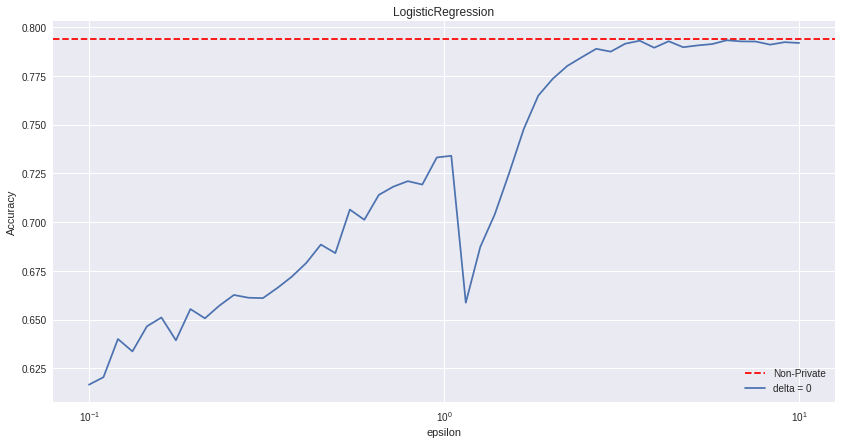

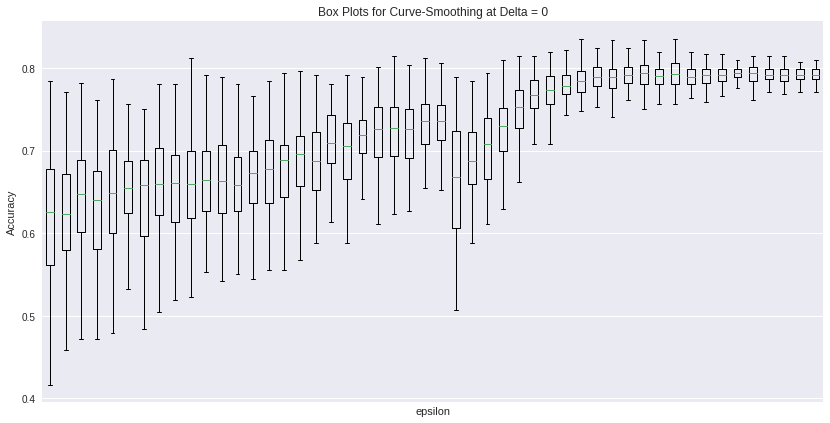

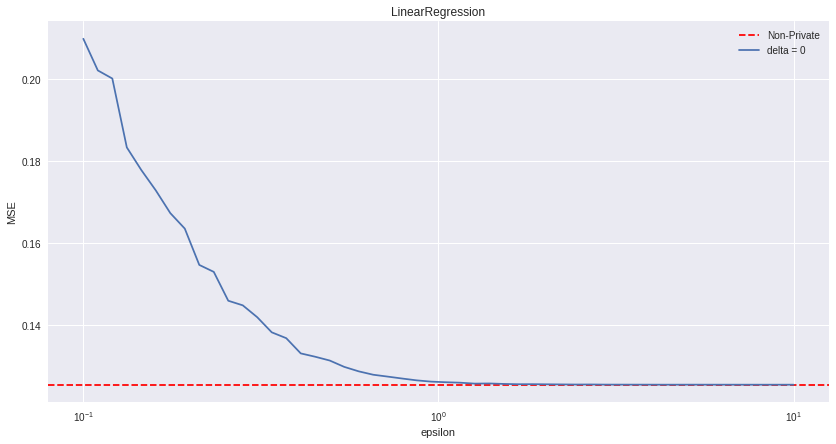

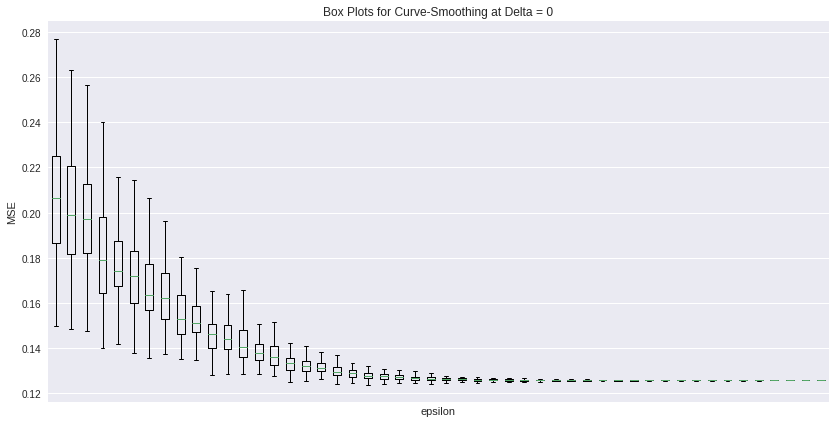

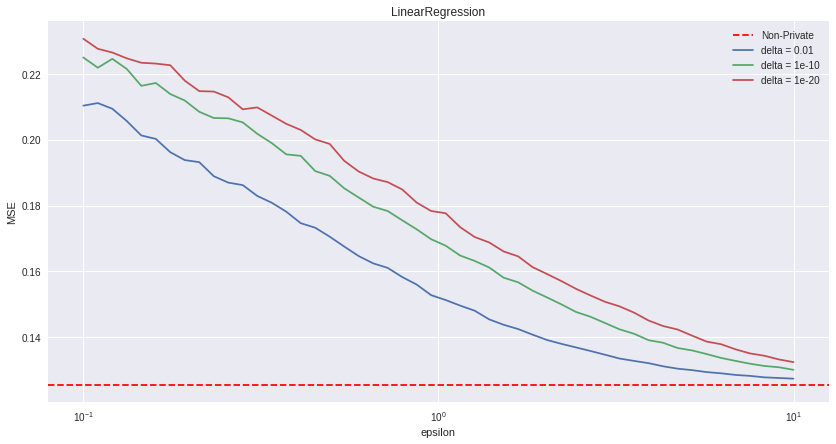

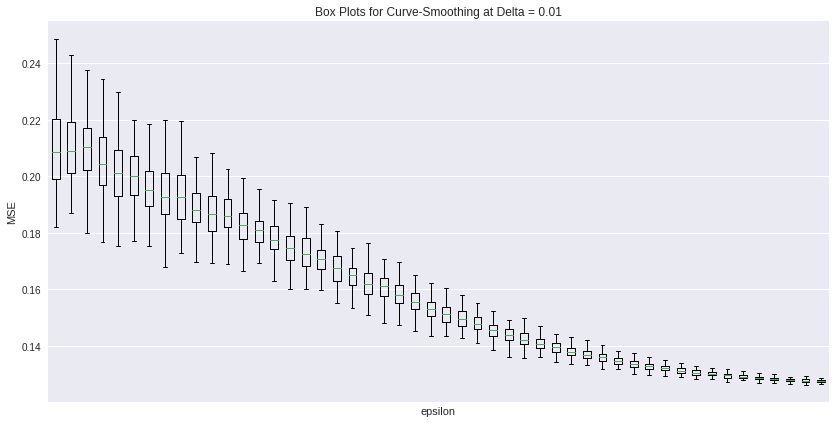

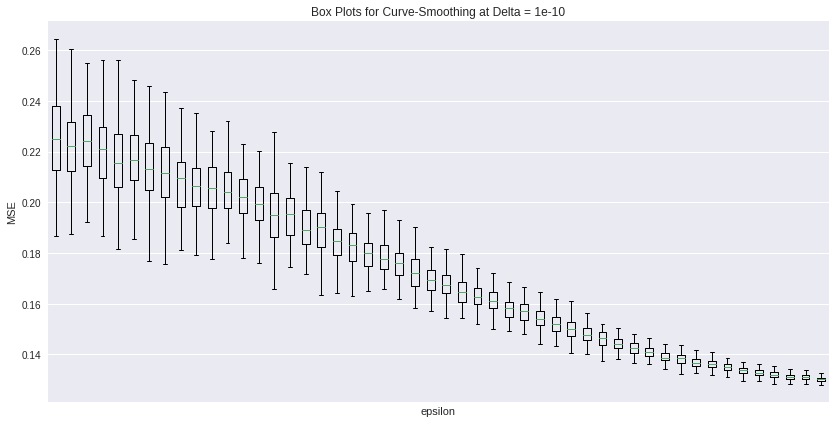

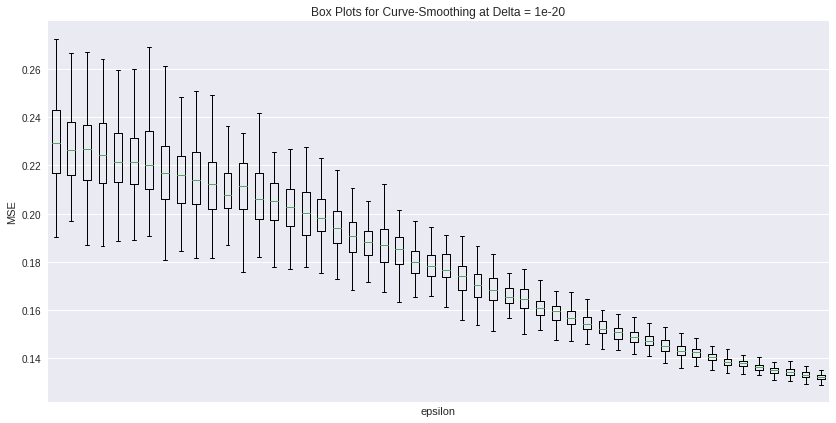


Total execution time: 137.0 s



In [4]:
import pandas as pd

# load cars data
import glob
path='/home/krudavsk/dp_test/datasets/'
folder = glob.glob(path + "car.data")
for file in folder:
    df=pd.read_csv(file, header=None)

# clean data
df= df.drop(df[df.eq('?').any(1)].index)
df= df.apply(pd.to_numeric, errors='ignore')

# make dummy variables
df = pd.get_dummies(df)

# drop last three cols
df = df.drop(df.columns[-3:], axis=1)

# extract features and label
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].astype('int')

#normalize
from sklearn import preprocessing
X = preprocessing.Normalizer(norm='l2').fit_transform(X)
# if round(max(y), 10) > 1.0: y /= max(y)

print(f' Running cars: {len(y)} entries '.upper().center(50,'*')+'\n')

run_dataset(X, y, deltas = [1e-2, 1e-10, 1e-20], name='cars', num_points = 50)

del df, X, y

In [5]:
# CENSUS DATASET
import pandas as pd
import numpy as np

import glob
path='/home/krudavsk/dp_test/datasets/'
folder = glob.glob(path + "adult.data")
for file in folder:
    df= pd.read_csv(file, header=None)

# clean data
df= df.drop(df[df.eq('?').any(1)].index)
df= df.apply(pd.to_numeric, errors='ignore')

# make dummy variables
df = pd.get_dummies(df, columns=[1,3,5,6,7,8,9,13,14])

# remove last column becaue as same second to last
df = df.drop(df.columns[-1], axis=1)

# extract features and label
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].astype('int')

#scale
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
    
#normalize
from sklearn import preprocessing
X = preprocessing.Normalizer(norm='l2').fit_transform(X)
# if round(max(y), 10) > 1.0: y /= max(y)

print(f' Running adult census: {len(X)} entries '.upper().center(50,'*')+'\n')
run_dataset(X, y, deltas = [1e-2, 1e-10, 1e-20], name='census', num_points = 50)
# run_dataset(x, y, deltas = [1/(len(x))])
# run_dataset(x, y, deltas = [1/(len(x)*100)])
# run_dataset(x, y, deltas = [1/2**30])
del df, X, y

/home/krudavsk/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


****** RUNNING ADULT CENSUS: 32561 ENTRIES *******

Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] cores
importing sys on engine(s)
importing metrics from sklearn on engine(s)
importing diffprivlib.models on engine(s)
importing numpy on engine(s)


KeyboardInterrupt: 

**** RUNNING CALI HOUSING SET: 20640 ENTRIES *****

Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] cores
importing sys on engine(s)
importing metrics from sklearn on engine(s)
importing diffprivlib.models on engine(s)
importing numpy on engine(s)


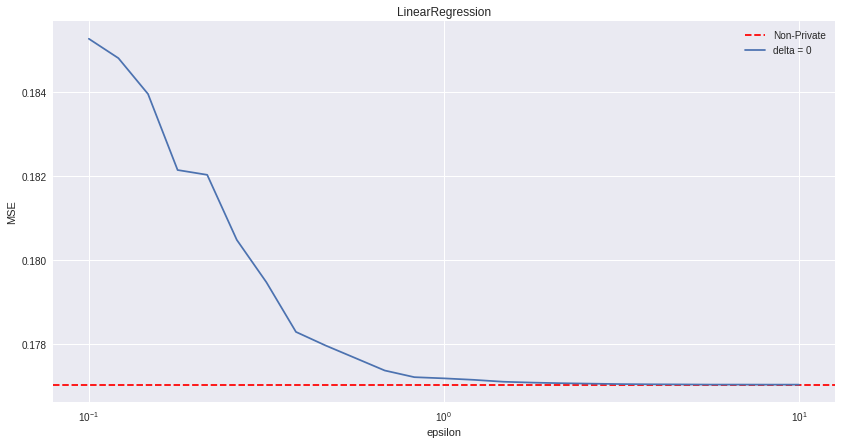

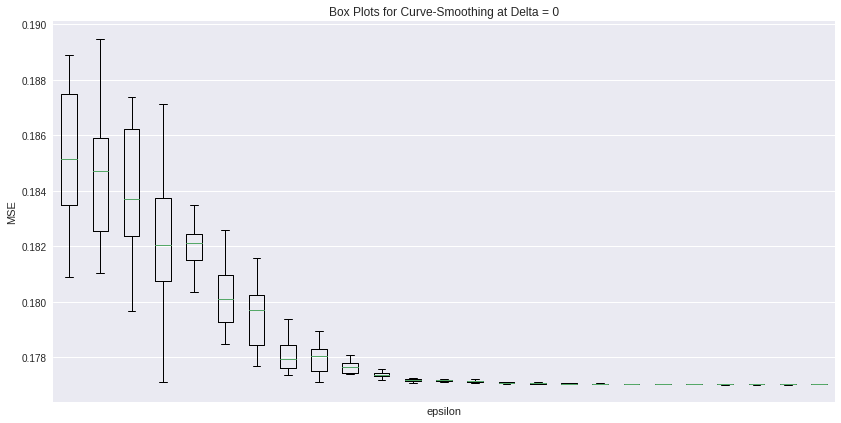

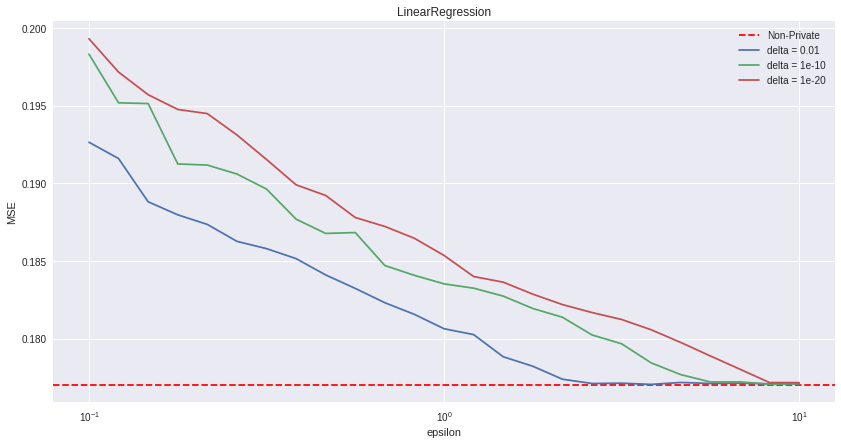

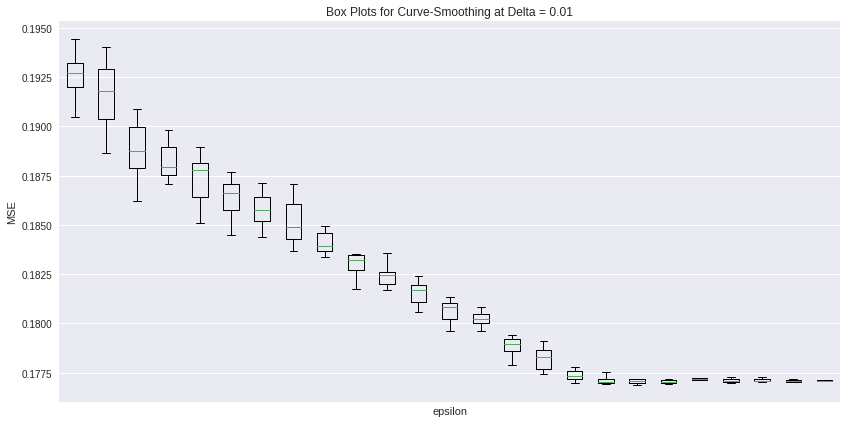

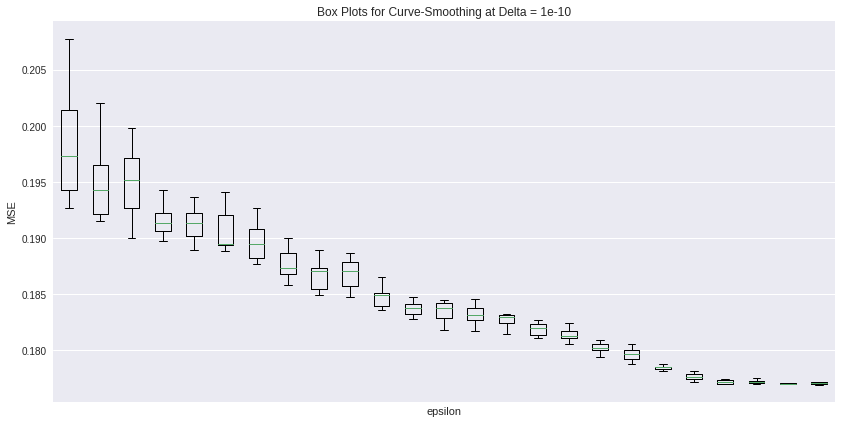

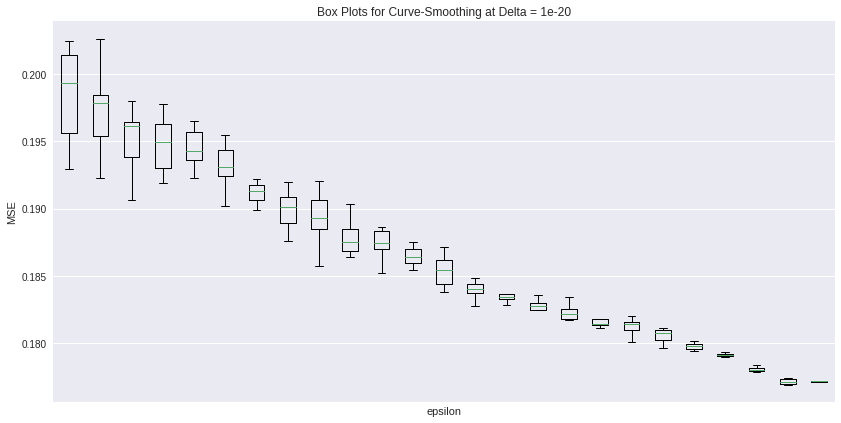


Total execution time: 10.0 s



In [5]:
# CALI HOUSING DATASET
from sklearn import datasets
import numpy as np
from sklearn import preprocessing

var=datasets.fetch_california_housing()
X = var.data
y = var.target

assert not np.isnan(y).any() and not np.isnan(X).any()
assert not np.isinf(y).any() and not np.isinf(X).any()

# scale & normalize
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = preprocessing.Normalizer(norm='l2').fit_transform(X)
if round(max(y), 10) > 1.0: y /= max(y)
    
print(f' Running CALI HOUSING set: {len(X)} entries '.upper().center(50,'*')+'\n')

run_dataset(X, y, deltas = [1e-2, 1e-10, 1e-20], mode='reg', name='housing')

del var, X, y

****** RUNNING COVTYPE SET: 581012 ENTRIES *******

Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] cores
importing sys on engine(s)
importing metrics from sklearn on engine(s)
importing diffprivlib.models on engine(s)
importing numpy on engine(s)


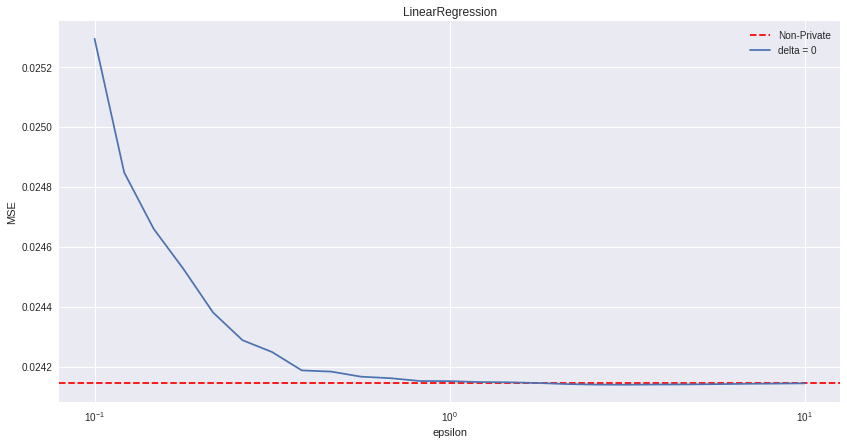

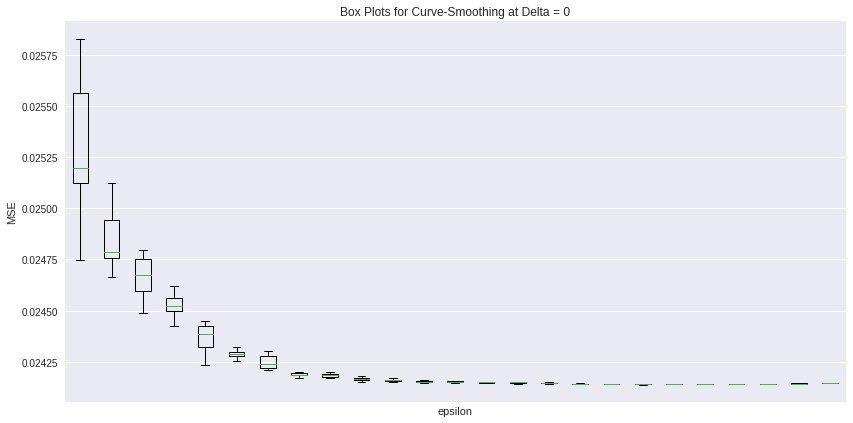

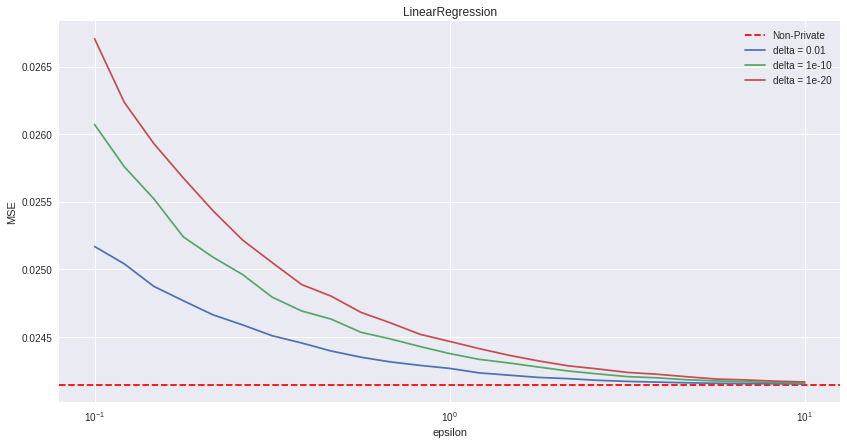

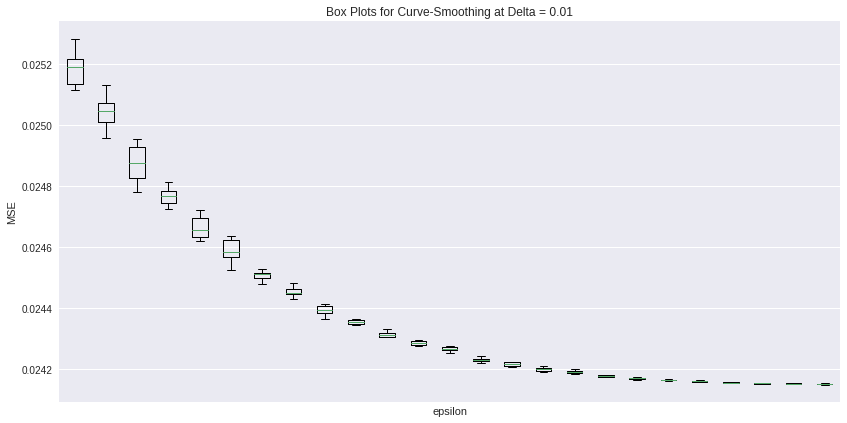

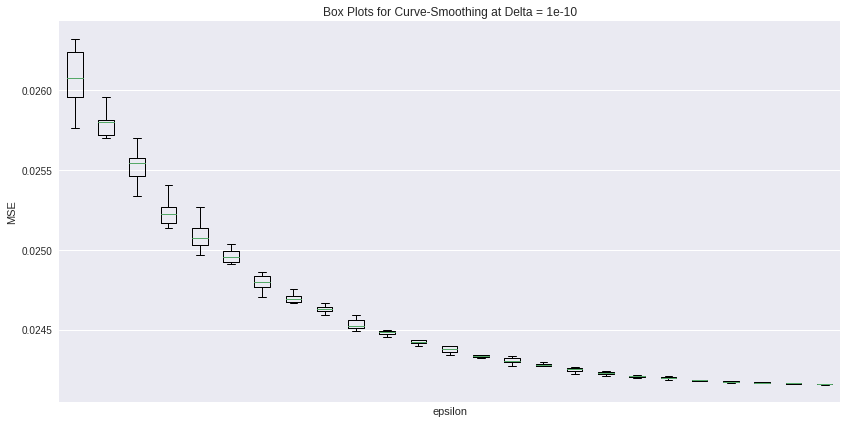

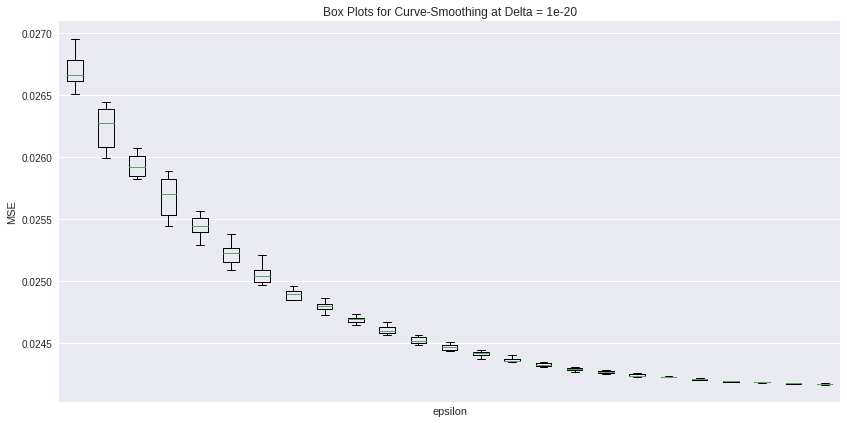


Total execution time: 97.0 s



In [4]:
import pandas as pd
from sklearn import preprocessing

# COVTYPE DATASET
from sklearn import datasets
var=datasets.fetch_covtype()
X = var.data
y = var.target

y = pd.get_dummies(y).values[:,-1]

# scale & normalize
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = preprocessing.Normalizer(norm='l2').fit_transform(X)
    # X = np.hstack((np.zeros((X.shape[0], 1)), X))
# if round(max(y), 10) > 1.0: y /= max(y)

# X=X[0:100000];y=y[0:100000]

print(f' Running covtype set: {len(X)} entries '.upper().center(50,'*')+'\n')
run_dataset(X, y, deltas = [1e-2, 1e-10, 1e-20], name='covtype', mode='reg')

del var, X, y

**** RUNNING CALI HOUSING SET: 20640 ENTRIES *****

Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] cores
importing sys on engine(s)
importing metrics from sklearn on engine(s)
importing diffprivlib.models on engine(s)
importing numpy on engine(s)


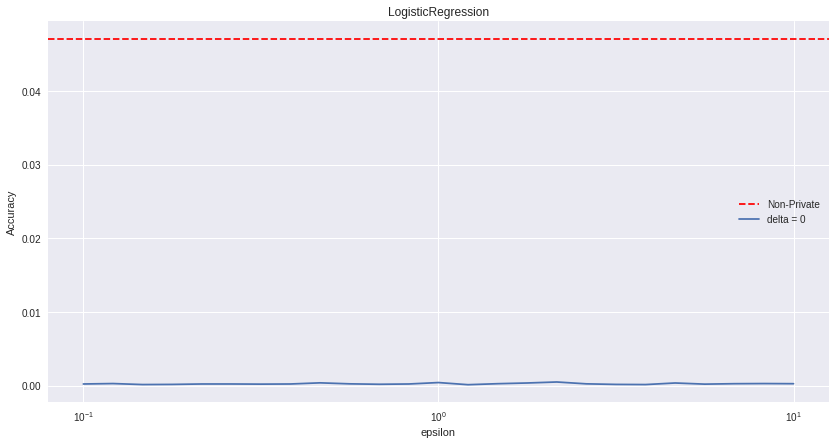

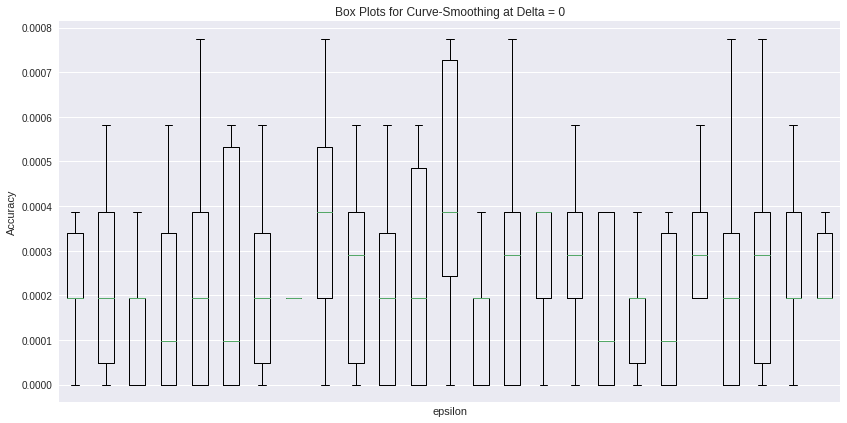


Total execution time: 1098.0 s



In [5]:
# CALI HOUSING DATASET
from sklearn import datasets
import numpy as np
from sklearn import preprocessing

var=datasets.fetch_california_housing()
X = var.data
y = var.target

assert not np.isnan(y).any() and not np.isnan(X).any()
assert not np.isinf(y).any() and not np.isinf(X).any()

# scale & normalize
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = preprocessing.Normalizer(norm='l2').fit_transform(X)
if round(max(y), 10) > 1.0: y /= max(y)
    
print(f' Running CALI HOUSING set: {len(X)} entries '.upper().center(50,'*')+'\n')

from sklearn.linear_model import LogisticRegression as logreg

lab_enc = preprocessing.LabelEncoder()
# X = lab_enc.fit_transform(X)
y = lab_enc.fit_transform(y)


run_dataset(X, y, deltas = [1e-2, 1e-10, 1e-20], mode='logreg', name='housing')
# logreg().fit(X,y)

del var, X, y

In [ ]:
(0.0265-0.0260)/0.0265

## Conclusion

1e0

In [ ]:
1e0

In [ ]:
1e1

In [ ]:
1e2